## 전체 학습 과정 예상도

1. HR_RAW --> LR_RAW (여기 나타난 코드 사용)
2. LR_RAW --> SR_RGB (학습 모델 사용)
3. Loss 계산: compare(SR_RGB, HR_RGB)

원본 데이터에 HR_RGB(.jpg 파일)는 crop

# Requirements

- rawpy
- imageio
- numpy
- cv2

## TODO

- patch를 랜덤한 위치에 만들었을 때(보통 64x64 크기), 이미지가 고해상도일 수록 patch가 거의 단색일 확률이 높음.

### 디렉토리 구성

```
+ 프로젝트 폴더
  + data
    + train
      + 00001
      + 00004
        - 00001.ARW
        - 00001.JPG
        - 00002.ARW
        - 00002.JPG
        - ...
    + test
      + 00007
      + 00022
      + ...
    + out (출력 파일들이 들어갈 곳)
      + train
        - 00001_00001.npz (train의 00001폴더의 00001.ARW 를 변환한 것)
        - 00001_00002.npz
        - ...
      + test
        - 00007_00001.npz
        - 00007_00002.npz
        - ...
```

# 데이터 만드는 방법

In [25]:
import random
import sys
from pathlib import Path
from multiprocessing import Pool

import cv2
import imageio
import numpy as np
import rawpy
from PIL import Image
from functools import partial
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

import matplotlib.pyplot as plt
import rawpy

In [2]:
def imshows(*ims, figsize=None, titles=[]):
    figsize = figsize or (len(ims) * 6, 4)
    plt.figure(figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(1, len(ims), i + 1)
        plt.imshow(im)
        if len(titles) > i:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()


def normalize(x: np.ndarray):
    if x.dtype != np.float32:
        x = x.astype(np.float32)

    maxx = x.max()
    minx = x.min()
    return (x - minx) / (maxx - minx)

In [3]:
# zoom-learn-zoom/utils.py
def get_bayer(path, black_lv=512, white_lv=16383):
    if isinstance(path, str) or isinstance(path, Path):
        raw = rawpy.imread(str(path))
    else:
        raw = path

    bayer = raw.raw_image_visible.astype(np.float32)
    bayer = (bayer - black_lv) / (white_lv - black_lv)  # subtract the black level
    return bayer

## Hyperparameter Configuration

In [4]:
data_dir = Path(r"/data/paul/")
out_dir = Path(r"/data/paul/out")

scale = 2  # 2배 축소

In [5]:
out_dir.exists()

True

In [6]:
(out_dir / "train").mkdir(parents=True, exist_ok=True)
(out_dir / "test").mkdir(parents=True, exist_ok=True)

## 파일 목록 확인

In [7]:
train_files = sorted(list((data_dir / "train" ).rglob("*.ARW")))
test_files = sorted(list((data_dir / "test" ).rglob("*.ARW")))
train_files[:10]

[PosixPath('/data/paul/train/00001/00001.ARW'),
 PosixPath('/data/paul/train/00001/00002.ARW'),
 PosixPath('/data/paul/train/00001/00003.ARW'),
 PosixPath('/data/paul/train/00001/00004.ARW'),
 PosixPath('/data/paul/train/00001/00005.ARW'),
 PosixPath('/data/paul/train/00001/00006.ARW'),
 PosixPath('/data/paul/train/00001/00007.ARW'),
 PosixPath('/data/paul/train/00004/00001.ARW'),
 PosixPath('/data/paul/train/00004/00002.ARW'),
 PosixPath('/data/paul/train/00004/00003.ARW')]

In [8]:
for i, file in enumerate(train_files):
    try:
        rawpy.imread(str(file))
    except:
        print(i, file)
        continue

In [9]:
# 깨진 이미지가 있습니다. 제외시켜줍니다.
train_files = train_files[:1698] + train_files[1701:]

In [10]:
len(train_files)

3373

In [11]:
# JPG 파일들. ARW만 있고, JPG는 없는 경우 제외
train_files = list(filter(lambda file: (file.parent / f"{file.stem}.JPG").exists(), train_files))
test_files = list(filter(lambda file: (file.parent / f"{file.stem}.JPG").exists(), test_files))

train_rgb_files = [(file.parent / f"{file.stem}.JPG") for file in train_files]
test_rgb_files = [(file.parent / f"{file.stem}.JPG") for file in test_files]

In [12]:
len(test_files)

336

## Data Visualization

### RAW bayer(=HR_RAW) 출력

In [21]:
r = rawpy.imread(str(train_files[0]))

In [22]:
bayer = get_bayer(r)
bayer.shape

(2848, 4256)

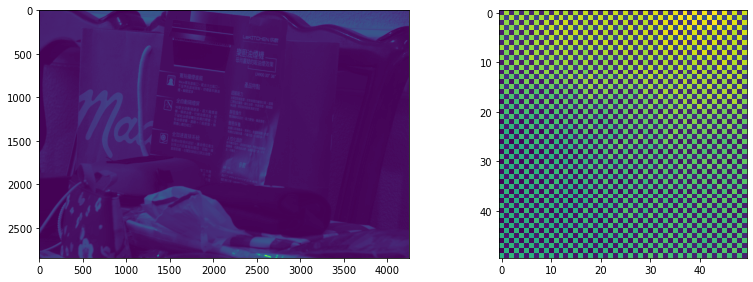

In [23]:
imshows(bayer, bayer[:50, :50])

bayer는 체스판 구조로 되어있습니다.

```
R G1
G2 B
```

### RGB 영상 (=HR_RGB) 출력

In [24]:
hr_rgb_ = imageio.imread("dataset/SRRAW/train/rgb_HR/00001.JPG")
hr_rgb_.shape

(2832, 4236, 3)

**HR_RAW에 비해서 가로세로 16pixel씩 잘려나갔음(이유 불명)**

이 16pixel을 고정되게 자른거면 문제 없는데, 파일마다 왼쪽 16pixel이기도 하고, 어떤건 좌우 8pixel씩이기도 하고...  
그래서 그냥 HR_RGB를 직접 만들어주기로 했습니다. 대신 색깔이 약깐 다를 수 있습니다.

필요하다면 postprocess의 하이퍼 파라미터를 변경해주세요

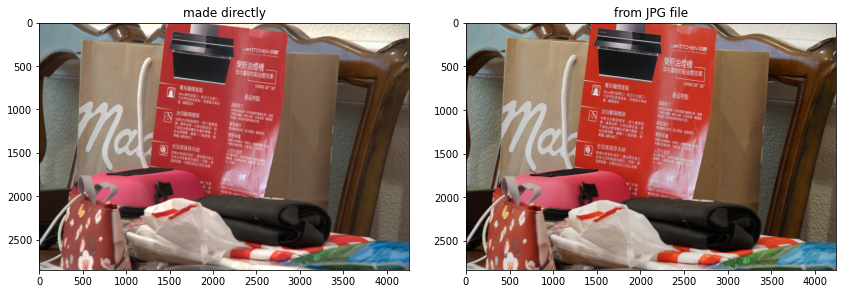

In [34]:
hr_rgb = r.postprocess(use_camera_wb=True, user_black=512, user_sat=16383, output_bps=8)
imshows(hr_rgb, hr_rgb_, titles=["made directly", "from JPG file"])

## WB 값 확인

WB는 아마도 white balance를 말하는 듯?

zoom-learn-zoom/utils.py 에 있는 compute_wb 함수를 씁니다.

In [13]:
def compute_wb(raw):
    # print("Computing WB for %s" % (raw_path))
    if isinstance(raw, str) or isinstance(raw, Path):
        bayer = rawpy.imread(str(raw))
    else:
        bayer = raw  # rawpy object일 경우

    # bayer = rawpy.imread(raw_path)
    rgb_nowb = bayer.postprocess(gamma=(1, 1), no_auto_bright=True, use_camera_wb=False, output_bps=16)

    rgb_wb = bayer.postprocess(gamma=(1, 1), no_auto_bright=True, use_camera_wb=True, output_bps=16)

    wb = [
        np.mean(rgb_wb[..., 0]) / np.mean(rgb_nowb[..., 0]),
        np.mean(rgb_wb[..., 1]) / np.mean(rgb_nowb[..., 1]),
        np.mean(rgb_wb[..., 1]) / np.mean(rgb_nowb[..., 1]),
        np.mean(rgb_wb[..., 2]) / np.mean(rgb_nowb[..., 2]),
    ]
    wb = np.array(wb, dtype=np.float32)
    return wb

In [14]:
compute_wb(r)

NameError: name 'r' is not defined

이 wb 값은

`SR_RGB = model(LR_RAW) * pow(wb, 1/2.2)`

으로 SR_RGB를 구할 때 씁니다. 1/2.2는 zoom-learn-zoom/inference.py 에서 가져왔습니다.

## LR_RAW 생성

bayer를 4채널 이미지로 만들면 단순히 cv2.resize로 줄여줄 수 있습니다.

In [15]:
def get_4ch(bayer):
    h, w = bayer.shape[:2]
    rgba = np.zeros((h // 2, w // 2, 4), dtype=np.float32)
    rgba[:, :, 0] = bayer[0::2, 0::2]  # R
    rgba[:, :, 1] = bayer[1::2, 0::2]  # G1
    rgba[:, :, 2] = bayer[1::2, 1::2]  # B
    rgba[:, :, 3] = bayer[0::2, 1::2]  # G2

    return rgba

In [16]:
def get_3ch(bayer):
    h, w = bayer.shape[:2]
    rgb = np.zeros((h // 2, w // 2, 3), dtype=np.float32)
    rgb[:, :, 0] = bayer[0::2, 0::2]  # R
    rgb[:, :, 1] = (bayer[1::2, 0::2] + bayer[0::2, 1::2])/2  # G1
    rgb[:, :, 2] = bayer[1::2, 1::2]  # B
    return rgb

In [17]:
def get_1ch(raw):
    h, w = raw.shape[:2]
    bayer = np.zeros((h * 2, w * 2), dtype=raw.dtype)
    bayer[0::2, 0::2] = raw[..., 0]
    bayer[1::2, 0::2] = raw[..., 1]
    bayer[1::2, 1::2] = raw[..., 2]
    bayer[0::2, 1::2] = raw[..., 3]

    return bayer

In [42]:
bayer.shape

(2848, 4256)

2차원 bayer를 3차원 4채널로 변형

## 데이터 생성

In [18]:
# def make_data(raw_path, rgb_path, scale, black_lv=512, white_lv=16383):
def make_data(raw_path, scale, black_lv=512, white_lv=16383):
    with rawpy.imread(str(raw_path)) as r:
        hr_bayer = r.raw_image_visible.astype(np.float32)
        hr_bayer = (hr_bayer - black_lv) / (white_lv - black_lv)
        wb = compute_wb(r)

        hr_rgb = r.postprocess(no_auto_bright=False, use_camera_wb=True, output_bps=8)
        #hr_rgb = r.postprocess(gamma=(1, 1), no_auto_bright=True, output_bps=8)
        # hr_rgb = imageio.imread(rgb_path)
        # hr_bayer = hr_bayer[8:-8, 8:-8]

    hr_raw = get_4ch(hr_bayer)
    h, w = hr_raw.shape[:2]
    lr_raw = cv2.resize(hr_raw, (w // scale, h // scale), interpolation=cv2.INTER_LINEAR)
    # lr_raw = hr_raw[0::scale, 0::scale]
    # lr_bayer = get_1ch(lr_raw)

    return lr_raw, hr_rgb, wb

### 여러번 테스트

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.7 µs


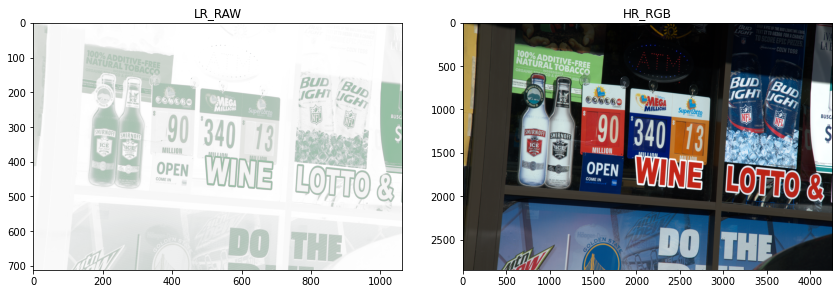

[0.78181654 0.96461666 0.96461666 1.2690978 ]


In [44]:
%time
# 랜덤한 파일 출력
j = random.randint(0, len(train_files) - 1)
lr_raw, hr_rgb, wb = make_data(train_files[j], 2)
imshows(lr_raw, hr_rgb, titles=["LR_RAW", "HR_RGB"])
print(wb)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.7 µs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


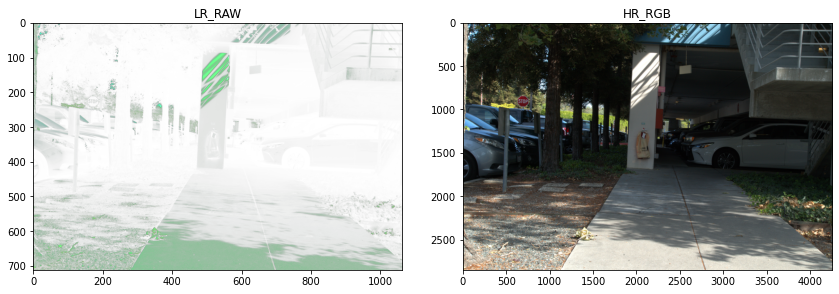

[0.7921961 0.9704024 0.9704024 1.303361 ]


In [45]:
%time
# 랜덤한 파일 출력
j = random.randint(0, len(train_files) - 1)
lr_raw, hr_rgb, wb = make_data(train_files[j], 2)
imshows(lr_raw, hr_rgb, titles=["LR_RAW", "HR_RGB"])
print(wb)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.2 µs


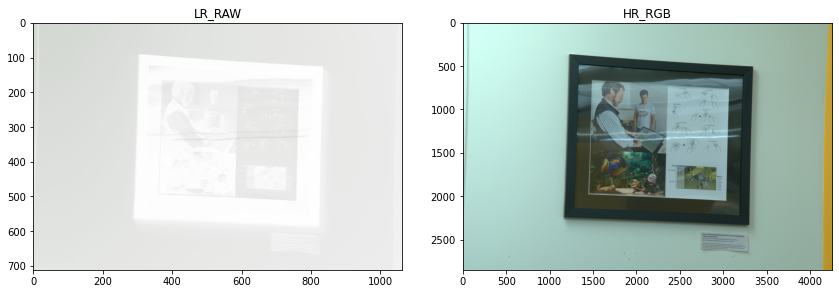

[0.37542713 0.9503572  0.9503572  4.033916  ]


In [46]:
%time
# 랜덤한 파일 출력
j = random.randint(0, len(train_files) - 1)
lr_raw, hr_rgb, wb = make_data(train_files[j], 2)
imshows(lr_raw, hr_rgb, titles=["LR_RAW", "HR_RGB"])
print(wb)

## Patch 생성

여기서 patch를 어떻게 만드는지는 zoom-learn-zoom/train.py 를 확인해보면 될 것 같습니다.  
일단 랜덤하게 64x64 크기로 만드는 코드는 아래와 같은데, 저자는 어떻게 했는지 확인해봐야될겁니다.

In [47]:
patch_size = 96

In [48]:
j = random.randint(0, len(train_files) - 1)
lr_raw, hr_rgb, wb = make_data(train_files[j], 2)

In [49]:
lr_raw.shape, hr_rgb.shape, wb

((712, 1064, 4),
 (2848, 4256, 3),
 array([0.6832784 , 0.93269074, 0.93269074, 1.8789921 ], dtype=float32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


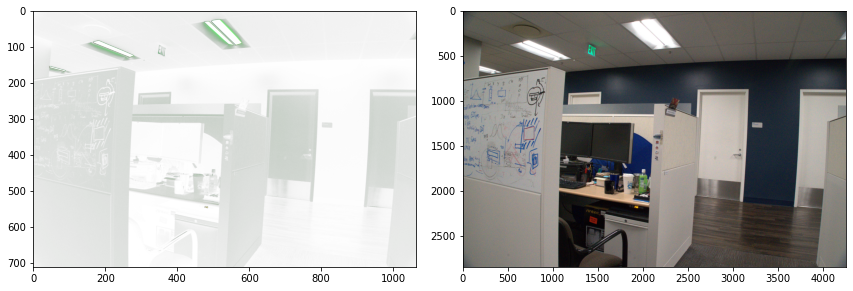

In [54]:
imshows(lr_raw, hr_rgb)

In [55]:
h, w = lr_raw.shape[:2]
p = patch_size
pos_x, pos_y = random.randint(0, w - p), random.randint(0, h - p)

In [56]:
pos_x, pos_y

(372, 357)

In [57]:
lr_raw_patch = lr_raw[pos_y : pos_y + p, pos_x : pos_x + p]
hr_rgb_patch = hr_rgb[pos_y * scale * 2 : (pos_y + p) * scale * 2, pos_x * scale * 2 : (pos_x + p) * scale * 2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


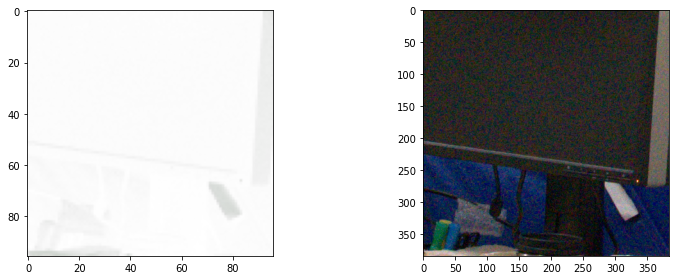

In [58]:
imshows(lr_raw_patch, hr_rgb_patch)

### 여러번 테스트

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


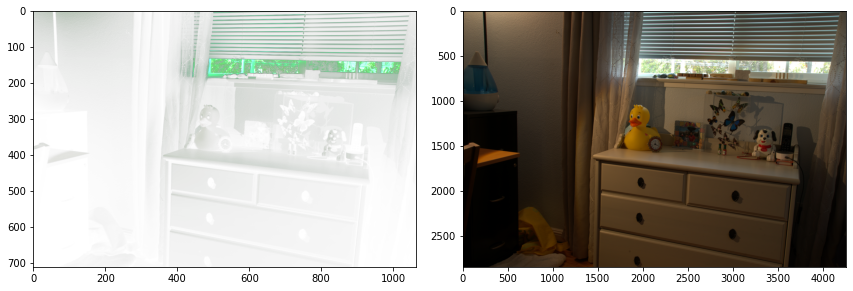

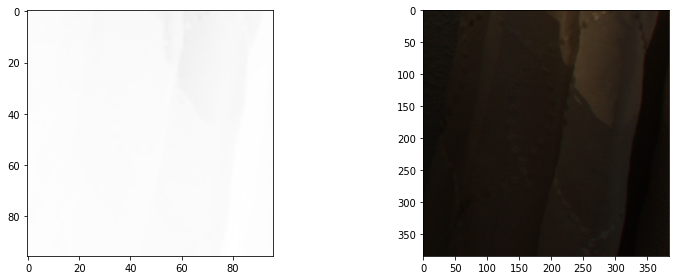

In [59]:
j = random.randint(0, len(train_files) - 1)
lr_raw, hr_rgb, wb = make_data(train_files[j], 2)
imshows(lr_raw, hr_rgb)

h, w = lr_raw.shape[:2]
p = patch_size
pos_x, pos_y = random.randint(0, w - p), random.randint(0, h - p)

lr_raw_patch = lr_raw[pos_y : pos_y + p, pos_x : pos_x + p]
hr_rgb_patch = hr_rgb[pos_y * scale * 2 : (pos_y + p) * scale * 2, pos_x * scale * 2 : (pos_x + p) * scale * 2]
imshows(lr_raw_patch, hr_rgb_patch)

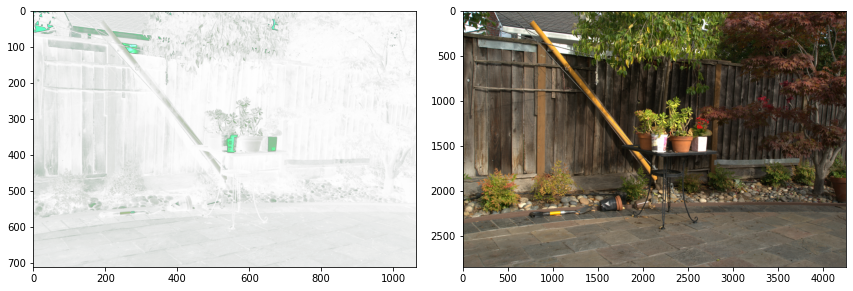

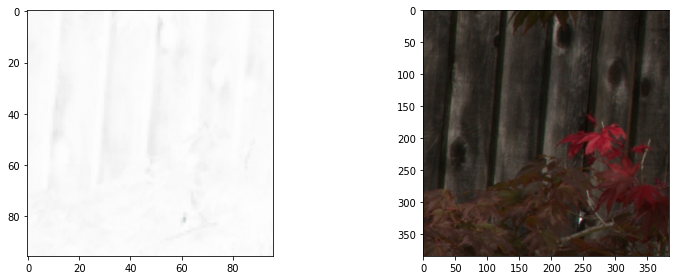

In [60]:
j = random.randint(0, len(train_files) - 1)
lr_raw, hr_rgb, wb = make_data(train_files[j], 2)
imshows(lr_raw, hr_rgb)

h, w = lr_raw.shape[:2]
p = patch_size
pos_x, pos_y = random.randint(0, w - p), random.randint(0, h - p)

lr_raw_patch = lr_raw[pos_y : pos_y + p, pos_x : pos_x + p]
hr_rgb_patch = hr_rgb[pos_y * scale * 2 : (pos_y + p) * scale * 2, pos_x * scale * 2 : (pos_x + p) * scale * 2]
imshows(lr_raw_patch, hr_rgb_patch)

## 모든 이미지에 대해 적용

In [19]:
num_patches_per_image = 100
patch_size = 96
scale = 2

In [28]:
def _T_make_data(raw_path, scale, out_dir, num_patches, patch_size):

    lr_raw, hr_rgb, wb = make_data(raw_path, scale)
    #print("Start patching... :", lr_raw.shape)
    for i in range(num_patches):
        h, w = lr_raw.shape[:2]
        p = patch_size
        pos_x, pos_y = random.randint(0, w - p), random.randint(0, h - p)

        lr_raw_patch = lr_raw[pos_y : pos_y + p, pos_x : pos_x + p]
        hr_rgb_patch = hr_rgb[pos_y * scale * 2 : (pos_y + p) * scale * 2, pos_x * scale * 2 : (pos_x + p) * scale * 2]
        hr_rgb_patch = hr_rgb_patch.astype(np.float32) / 255
        fpath = out_dir / f"{raw_path.parent.name}_{raw_path.stem}_{i:02d}.npz"
        np.savez_compressed(fpath, lr_raw=lr_raw_patch, hr_rgb=hr_rgb_patch, wb=wb)

    return raw_path

In [21]:
train_items = []
test_items = []
scale = 2
for file in train_files:
    train_items.append((file, scale, out_dir / "train", num_patches_per_image, patch_size))
for file in test_files:
    test_items.append((file, scale, out_dir / "test", num_patches_per_image, patch_size))

In [22]:
len(train_items)

2923

In [23]:
file.parts[-2:]

('00434', '00007.ARW')

In [ ]:
func = partial(_T_make_data, scale=2, out_dir=out_dir / "train", num_patches=20, patch_size=96)
result = process_map(func, train_files, max_workers=12, chunksize=8, desc="Train data creating...")

In [ ]:
func = partial(_T_make_data, scale=2, out_dir=out_dir / "test", num_patches=20, patch_size=96)
result = process_map(func, train_files, max_workers=12, chunksize=24, desc="test data creating...")

In [ ]:
with Pool(8) as pool:
    with tqdm(total=len(test_items), ncols=100, file=sys.stdout) as t:
        for file in pool.imap_unordered(_T_make_data, test_items):
            t.set_postfix_str("/".join(file.parts[-2:]))
            t.update()

In [ ]:
!du -sh data/p64_scale2_np50_v2/